In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [4]:
#From the dataset, the images are 256*256 and we keep them in a batch of 32
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [6]:
#My classes names
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

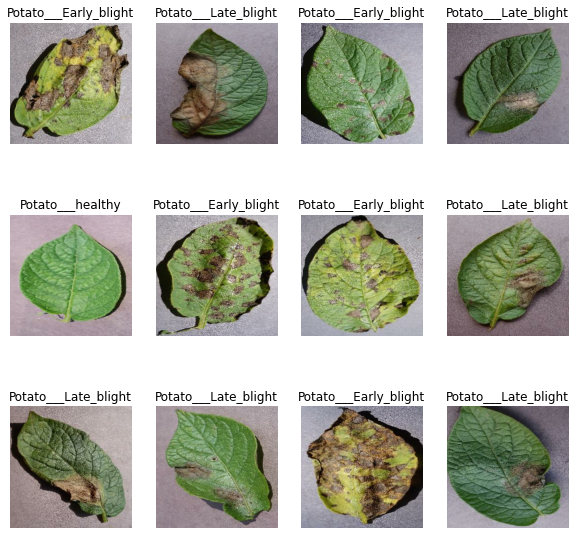

In [7]:
plt.figure(figsize=(10, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [8]:
#Here we will split our datas for training, validation and testing
# 80% ==> training
# 10% ==> vali and 10% ==> testing

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=1000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds


In [9]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [12]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [13]:
#Let's build our model
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'),
])

model.build(input_shape = input_shape)

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [16]:
   model.compile(
       optimizer = 'adam',
       loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
       metrics = ['accuracy']
   )

In [17]:
EPOCHS = 20

history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/20
54/54 [==============================] - 124s 2s/step - loss: 0.7849 - accuracy: 0.6296 - val_loss: 0.4603 - val_accuracy: 0.8594
Epoch 2/20
54/54 [==============================] - 123s 2s/step - loss: 0.3940 - accuracy: 0.8547 - val_loss: 0.3049 - val_accuracy: 0.8802
Epoch 3/20
54/54 [==============================] - 118s 2s/step - loss: 0.3198 - accuracy: 0.8738 - val_loss: 0.4310 - val_accuracy: 0.8333
Epoch 4/20
54/54 [==============================] - 121s 2s/step - loss: 0.2373 - accuracy: 0.8866 - val_loss: 0.4729 - val_accuracy: 0.8333
Epoch 5/20
54/54 [==============================] - 123s 2s/step - loss: 0.2072 - accuracy: 0.8999 - val_loss: 0.3153 - val_accuracy: 0.8594
Epoch 6/20
54/54 [==============================] - 116s 2s/step - loss: 0.1983 - accuracy: 0.9080 - val_loss: 0.4093 - val_accuracy: 0.8177
Epoch 7/20
54/54 [==============================] - 121s 2s/step - loss: 0.2343 - accuracy: 0.9097 - val_loss: 0.5100 - val_accuracy: 0.8073
Epoch 8/20
54

In [18]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 7s 600ms/step - loss: 0.0749 - accuracy: 0.9766


In [19]:
scores

[0.07490720599889755, 0.9765625]

In [20]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Accuracy')

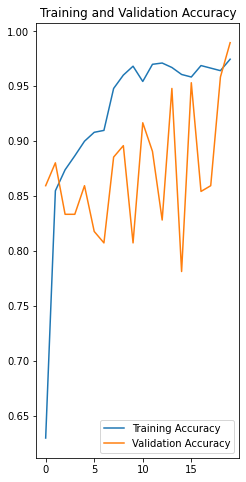

In [22]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

First image to predict
The first image's actual label:  Potato___Late_blight
predicted label:  Potato___Early_blight


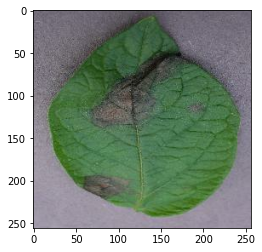

In [31]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print('First image to predict')
    plt.imshow(first_image)
    print("The first image's actual label: ", class_names[first_label])
    
    batch_prediction = model.predict(image_batch)
    print("predicted label: ", class_names[np.argmax(batch_prediction[0])])

In [32]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

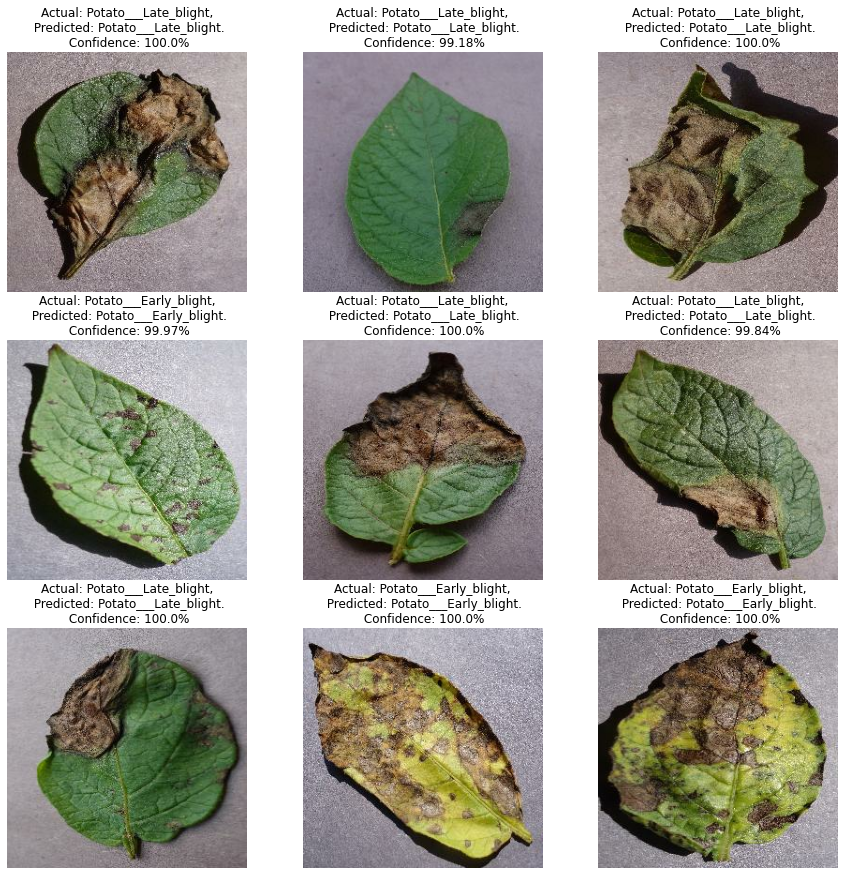

In [33]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [ ]:
# import os
# model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
# model.save(f"../models/{model_version}")

In [35]:
import os
model_version=max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2\assets
